In [1]:
import torch
import torchvision
from scipy.io import loadmat
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import os
from torchvision import transforms as T
from utils import datsprwtrans as prw
from torch import device
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from IPython.display import clear_output

## Transfer Learning Model

Function to generate our model.

In [2]:
def get_model(num_classes):
    """Create a object detection model."""
    
    # load a model pre-trained on MSCOCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

Lets define our custom dataset which will load in our images and annotations.

In [3]:
class PRWTransfer(torch.utils.data.Dataset):
    """Creates a PRW dataset for a Object Detection model."""
    
    def __init__(self, img_root, ann_root, transforms=None):
        """Instantiates the dataset."""
        
        # set the root directories for data.
        self.root_img = img_root
        self.root_ann = ann_root
        self.transforms = transforms
        
        # load all image files, sorting them to
        # ensure that they are aligned.
        self.imgs = list(sorted(os.listdir(img_root)))
        self.anns = list(sorted(os.listdir(ann_root)))

    def __getitem__(self, idx):
        """Gets a sample from the dataset."""
        
        # load images and bounding boxes.
        img_path = os.path.join(self.root_img, self.imgs[idx])
        ann_path = os.path.join(self.root_ann, self.anns[idx])
        ann = loadmat(ann_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        # get the height and width of the image
        image_width = img.shape[1]
        image_height = img.shape[0]
        img = cv2.resize(img, (416, 416))
        img /= 255.0
        
        if 'box_new' in ann.keys():
            ann = ann['box_new']
        elif 'anno_file' in ann.keys():
            ann = ann['anno_file']
        elif 'anno_previous' in ann.keys():
            ann = ann['anno_previous']
        else:
            raise ValueError("Invalid Annotation Error")

        # get bounding box coordinates for each mask.
        bbox = [a[1:] for a in ann]
        for i in bbox:
            xmin = i[0]
            xmax = xmin + i[2]
            ymin = i[1]
            ymax = ymin + i[3]
            xmin = (xmin/image_width)*416
            xmax = (xmax/image_width)*416
            ymin = (ymin/image_height)*416
            ymax = (ymax/image_height)*416
            i[:] = [xmin, ymin, xmax, ymax]
        
        # store boxes as a tensor.
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        # there is only one class.
        labels = torch.ones((len(bbox),), dtype=torch.int32)
        
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = torch.FloatTensor(boxes)
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply transform if required.
        if self.transforms:
            sample = self.transforms(image = img,
                                     bboxes = target['boxes'],
                                     labels = labels)
            for b in sample['boxes']:
                (x1, y1, x2, y2) = b
                for a in range(4):
                    b[a] = math.floor(b[a]) if b[a] > 1 else b[a]
                    b[a] = math.ceil(b[a]) if b[a] < 0 else b[a]
                        
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        """Gets the size of the dataset (number of samples)."""
        
        return len(self.imgs)

Defines the transforms for our image. Most of the preprocessing is built into the existing model, so we just need to convert to tensors.

In [4]:
# define the training tranforms
def get_transform():
    return A.Compose([ToTensorV2(p=1.0),], 
                     bbox_params={'format': 'pascal_voc',
                                  'label_fields': ['labels']})

Dataloader helper. The dataset will output variable size data so we need to work with a custom data getter.

In [5]:
def collate_fn(batch):
    """Dataloader data gatherer."""
    
    return tuple(zip(*batch))

Create a Torch device for memory management and GPU processes and create an instance of the model.

In [6]:
# set the device.
device = device('mps' if torch.has_mps else 'cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
print('Model Set')

Model Set


Create a training function.

In [8]:
# function for running training iterations
def train(train_data_loader, model):
    """Trains the model."""
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    
    for data in train_data_loader:
        # zero oput the gradients.
        optimizer.zero_grad()
        images, targets = data
        
        # move the target data and the image to device.
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # calculate the loss.
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # record the loss. (Tracking)
        totalTrainLoss += losses
        
        # backpropagate the error.
        losses.backward()
        optimizer.step()
        
    return totalTrainLoss

Create a validation function.

In [9]:
# function for running validation iterations
def validate(valid_data_loader, model):
    """Validates the model."""
    
    totalValLoss = 0
    
    for data in valid_data_loader:
        # unpack the data.
        images, targets = data
        
        # move images and target data to device. 
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # turn off gradient tracking.
        with torch.no_grad():
            loss_dict = model(images, targets)
            
        # calculate the loss.
        losses = sum(loss for loss in loss_dict.values())
        totalValLoss += losses
        
    return totalValLoss

Now lets generate the dataset and load it to a Torch dataloader for training and evaluation.

In [10]:
BATCH = 5

# define required data directories.
img_path = r'/Users/chiahaohsutai/Documents/GitHub/PRW/images/frames'
ann_path = r'/Users/chiahaohsutai/Documents/GitHub/PRW/annotations'

# use our dataset and defined transformations
dataset = prw.PRWTransfer(img_path, ann_path, get_transform())
dataset_test = prw.PRWTransfer(img_path, ann_path, get_transform())

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-1000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1000:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH, shuffle=True, num_workers=4,
    collate_fn=prw.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=BATCH, shuffle=False, num_workers=4,
    collate_fn=prw.collate_fn)

Train the model.

In [11]:
# freeze the backbone of the model.
for p in model.backbone.parameters():
    p.requires_grad = False

NUM_EPOCHS = 1
trainSteps = len(dataset) // BATCH
valSteps = len(dataset_test) // BATCH

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# for tracking histories.
train_loss_list = []
val_loss_list = []

# start the training epochs
for epoch in range(NUM_EPOCHS):
    
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(data_loader, model)
    val_loss = validate(data_loader_test, model)
    
    lr_scheduler.step()
    
    # print metrics.
    print(f"Epoch #{epoch+1} train loss: {train_loss:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    
    # calculate the average training and validation loss
    avgTrainLoss = train_loss / trainSteps
    avgValLoss = val_loss / valSteps
    
    train_loss_list.append(avgTrainLoss)
    val_loss_list.append(avgValLoss)
    
    clear_output()

Convert tensors to values.

In [16]:
for idx in range(len(train_loss_list)):
    train_loss_list[idx] = train_loss_list[idx].detach().cpu().numpy()
    val_loss_list[idx] = val_loss_list[idx].detach().cpu().numpy()

Save the model.

[INFO] saving object detector model...


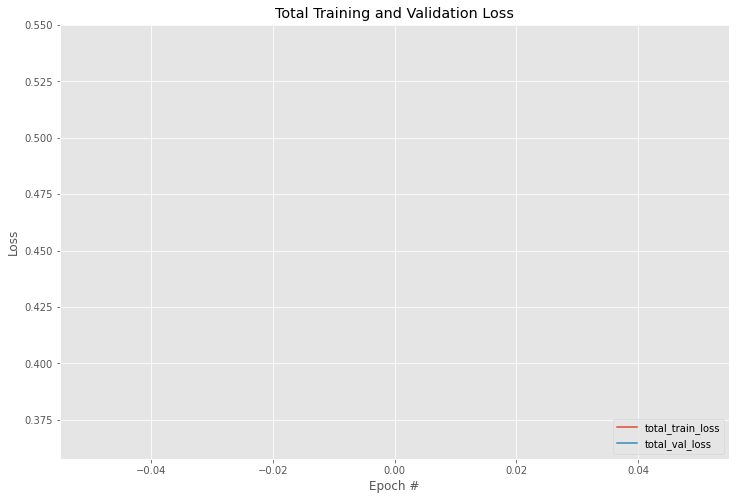

In [19]:
# path to current folder.
curr_dir = r'/Users/chiahaohsutai/Documents/GitHub/PedestrianDetection/save'
model_dir = os.path.join(curr_dir, 'model_transfer.pth')

# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(model, model_dir)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(train_loss_list, label="total_train_loss")
plt.plot(val_loss_list, label="total_val_loss")
plt.title("Total Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower right")

# save the training plot
plotPath = os.path.sep.join([curr_dir, "training_transfer.png"])
plt.savefig(plotPath)

# show the plot.
plt.show()

There is an error in loss tracking. I think we might have a bug due to using a Python list 

Evaluate the model.

In [20]:
# move the model to device.
model.eval().to(device)
print('Model in Eval Mode')

Model in Eval Mode


In [21]:
def predict(photo, model, device, thresh):
    
    with torch.no_grad():
        outputs = model(photo.to(device))
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        # get the boxes and the scores.
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        labels = outputs[0]['labels'].cpu().numpy()

        # filter out boxes according to `detection_threshold`
        labels = labels[scores >= thresh].astype(np.int32)
        boxes = boxes[scores >= thresh].astype(np.int32)
        boxes = boxes[labels == 1]

    return boxes

In [22]:
def iou(boxA, boxB):
    """Calculates Intersection Over Union."""
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou

def get_boxes(ann):
    """Gets the correct key for annotations."""
    
    keys = ann.keys()
    key = None
    
    # get the correct key for the bouding box.
    for k in ['box_new', 'anno_file', 'anno_previous']:
        if k in keys:
            key = k
            break
    if key is None:
        raise ValueError("Invalid Annotation Error")
    
    # get the bounding boxes and convert to coordinates.
    bbox = [box[1:] for box in ann[key]]
    for box in bbox:
        xmin, ymin, w, h = box
        xmax, ymax = xmin+w, ymin+h
        box[-2] = xmax
        box[-1] = ymax
        
    return bbox

In [23]:
import numpy as np

In [24]:
# get the image names.
images_names = sorted(list(os.listdir(img_path)))
images_names = [os.path.join(img_path, name) for name in images_names]

# get the annoation names.
ann_names = sorted(list(os.listdir(ann_path)))
ann_names = [os.path.join(ann_path, name) for name in ann_names]

Calculate the evaluation metrics.

In [27]:
total_iou = []
# truth, pred
total_count = []
total = len(images_names)

# evaluate the model.
for idx in indices[-1000:]:
    image, ann = images_names[idx], ann_names[idx]
    
    # get appropiate data.
    data = loadmat(ann)
    photo = cv2.imread(image)
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    photo /= 255.0
    
    # bring color channels to front
    photo = np.transpose(photo, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    photo = torch.tensor(photo, dtype=torch.float)
    # add batch dimension
    photo = torch.unsqueeze(photo, 0)
    
    gt = get_boxes(data)
    
    # get a prediction
    pred = predict(photo, model, device, 0.7)
    
    # go through the prediciton and calulate iou
    boxes = pred
    for bbox in boxes:
        # get the iou.
        union = 0
        for b in gt:
            union = max(union, iou(b, bbox))
        if union > 0.25:
            total_iou.append(union)
    
    # get a count of the boxes.
    total_count.append((len(gt), len(boxes)))

In [28]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [29]:
# extract the counts.
y_true = [c[0] for c in total_count]
y_pred = [c[1] for c in total_count]

mse_eval = MSE(y_true, y_pred, squared=False)
mape_eval = MAPE(y_true, y_pred)
avg_iou = sum(total_iou) / len(total_iou)

In [30]:
print(f'RMSE: {mse_eval}, MAPE: {mape_eval}, Avg. IOU: {avg_iou}')

RMSE: 4.094386400915282, MAPE: 1.126253651903652, Avg. IOU: 0.6601183056870884
